In [190]:
import pandas as pd
import geopandas as gpd
import folium
import matplotlib.pyplot as plt
import contextily as ctx
import requests
from shapely.geometry import Point
from datetime import datetime
from tqdm import tqdm
import time
from collections import defaultdict
import seaborn as sns
from prophet import Prophet
from scipy.optimize import curve_fit
import numpy as n
from scipy.interpolate import CubicSpline

In [2]:
SGMA = "../data/GWBasins.shp"

In [29]:
gdf = gpd.read_file(SGMA)
gdf.set_crs(epsg=3857, inplace=True)
gdf.set_index('OBJECTID', inplace=True)
gdf['Basin_Prefix'] = gdf['Basin_Numb'].str.split('-').str[0].astype(int)

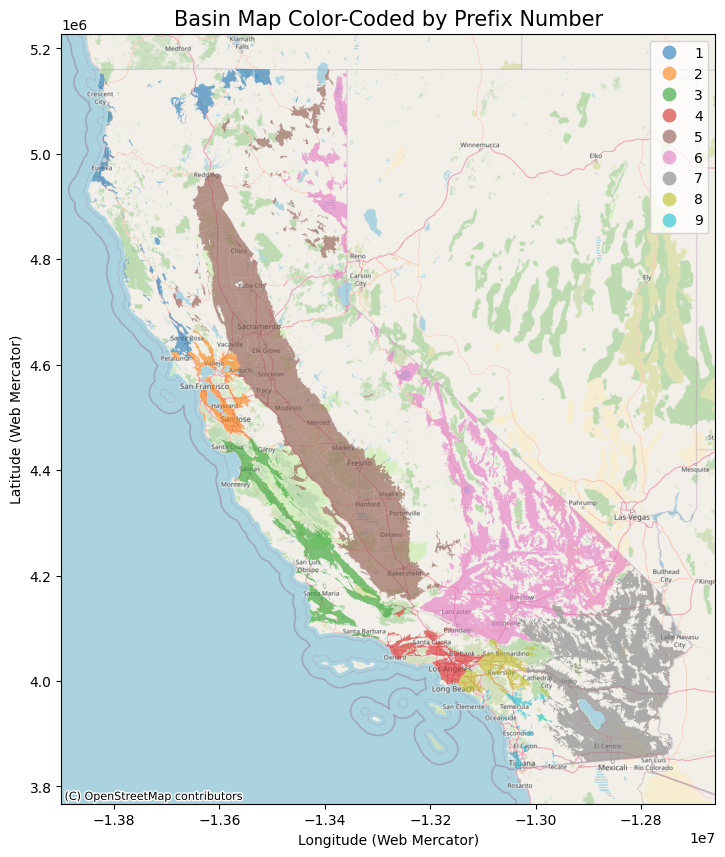

In [38]:
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(column='Basin_Prefix', ax=ax, legend=True, categorical=True, alpha=0.6)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_title("Basin Map Color-Coded by Prefix Number", fontsize=15)
ax.set_xlabel("Longitude (Web Mercator)")
ax.set_ylabel("Latitude (Web Mercator)")

plt.show()

In [41]:
central = gdf[gdf.Basin_Numb.str.startswith("5")].copy()

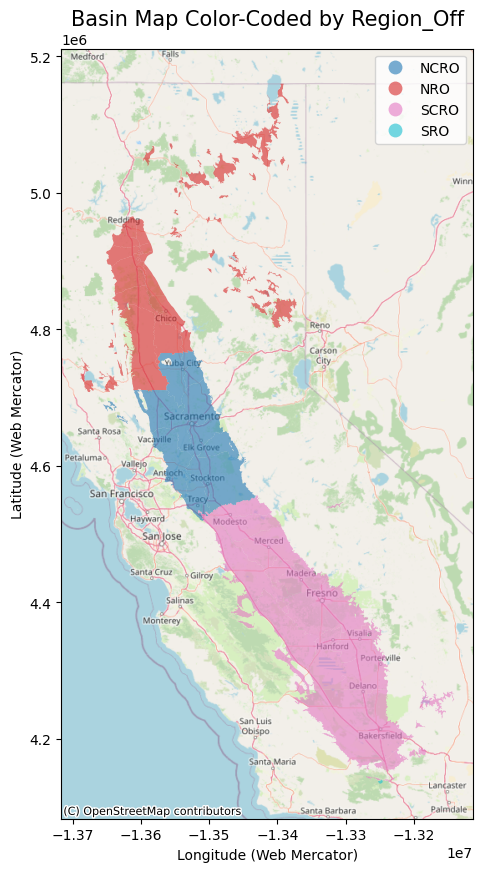

In [48]:
fig, ax = plt.subplots(figsize=(10, 10))
central.plot(column='Region_Off', ax=ax, legend=True, categorical=True, alpha=0.6)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_title("Basin Map Color-Coded by Region_Off", fontsize=15)
ax.set_xlabel("Longitude (Web Mercator)")
ax.set_ylabel("Latitude (Web Mercator)")

plt.show()

In [50]:
stations = pd.read_csv("../data/stations_depth_geology.csv", index_col="_id")

In [57]:
geometry = [Point(xy) for xy in zip(stations['longitude'], stations['latitude'])]
stations_geo = gpd.GeoDataFrame(stations, geometry=geometry, crs="EPSG:4326")
stations_geo = stations_geo.to_crs(epsg=3857)

In [60]:
joined_gdf = gpd.sjoin(stations_geo, central, how="left", predicate="within")

In [63]:
stations_geo["Basin_Numb"] = joined_gdf["Basin_Numb"]
stations_geo["Basin_Subb"] = joined_gdf["Basin_Subb"]

In [66]:
central_stations = stations_geo[~stations_geo.Basin_Numb.isna()].copy()

In [70]:
central_stations.Basin_Numb.value_counts()

Basin_Numb
5-022    4149
5-021    3052
5-012     122
5-006     103
5-004      41
5-015      36
5-002      22
5-005      22
5-023      13
5-025      12
5-001      11
5-058      10
5-028       8
5-014       5
5-029       5
5-013       5
5-036       5
5-027       5
5-007       4
5-019       4
5-016       3
5-035       2
5-018       2
5-011       2
5-026       2
5-008       2
5-080       1
5-047       1
5-059       1
5-083       1
5-017       1
Name: count, dtype: int64

In [74]:
central_stations['count'] = central_stations.groupby('Basin_Numb')['Basin_Numb'].transform('count')
central_stations = central_stations[central_stations['count'] >= 20].copy()
central_stations = central_stations.drop(columns=['count'])

In [76]:
central_stations.Basin_Numb.value_counts()

Basin_Numb
5-022    4149
5-021    3052
5-012     122
5-006     103
5-004      41
5-015      36
5-005      22
5-002      22
Name: count, dtype: int64

In [83]:
def get_precipitation_data(latitude, longitude, start_date, end_date, parameter="PRECTOTCORR"):
    base_url = "https://power.larc.nasa.gov/api/temporal/daily/point"
    
    params = {
        "parameters": parameter,
        "community": "AG",
        "longitude": longitude,
        "latitude": latitude,
        "start": start_date,
        "end": end_date,
        "format": "JSON"
    }

    response = requests.get(base_url, params=params)
    response.raise_for_status()

    data = response.json()

    try:
        precip_data = data["properties"]["parameter"][parameter]
    except KeyError as e:
        raise ValueError(f"Unable to retrieve parameter '{parameter}' from response: {e}")

    return precip_data

Pulls from NASA POWER API and uses corrected precipitation measurements.

In [86]:
xl = pd.ExcelFile("../data/water_use_2016_2020.xlsx")

In [98]:
central_stations.head()

,site_code,stn_id,swn,well_name,continuous_data_station_number,latitude,longitude,gse,rpe,gse_method,...,county_name,well_depth,well_use,well_type,wcr_no,monitoring_program,geology,geometry,Basin_Numb,Basin_Subb
_id,,,,,,,,,,,,,,,,,,,,,
10439,344779N1192479W001,47426,28S25E23J001M,Furrow #1,NaN,35.47786,-119.24792,344.0,346.00,USGS quad,...,Kern,600.0,Irrigation,Single Well,e060908,VOLUNTARY,['Qoa'],POINT (-13274617.733 4229011.528),5-022,5-022.14
16222,349662N1189211W001,57817,10N19W08A001S,RMW-WWB-002,NaN,34.96626,-118.92112,1250.2,1251.93,GPS,...,Kern,1765.0,Observation,Single Well,88711,SGMA,['Q'],POINT (-13238238.523 4159296.958),5-022,5-022.18
16239,349701N1188365W001,51672,10N18W06Q001S,MW1,NaN,34.97011,-118.83654,963.0,963.00,USGS quad,...,Kern,990.0,Observation,Single Well,785628-785629,VOLUNTARY,['Q'],POINT (-13228823.12 4159819.954),5-022,5-022.18
16286,349764N1188520W001,51673,10N19W01K001S,RMW-WWB-001,NaN,34.97631,-118.85275,950.4,951.74,GPS,...,Kern,460.0,Observation,Part of a nested/multi-completion well,785632-785633,SGMA,['Q'],POINT (-13230627.609 4160662.234),5-022,5-022.18
16287,349764N1188520W002,51674,10N19W01K002S,MW4B,NaN,34.97636,-118.85202,950.0,950.00,USGS quad,...,Kern,990.0,Observation,Part of a nested/multi-completion well,785632-785633,VOLUNTARY,['Q'],POINT (-13230546.346 4160669.026),5-022,5-022.18


In [140]:
def fetch_and_update_counts(year, counts):
    offset = 0
    limit = 10000
    while True:
        url = f"https://data.cnra.ca.gov/api/3/action/datastore_search?resource_id=bfa9f262-24a1-45bd-8dc8-138bc8107266&q={year}&limit={limit}&offset={offset}"
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            records = data['result']['records']
            for record in records:
                site_code = record.get('site_code')
                if record.get('gse_gwe') is None:
                    continue
                if site_code:
                    counts[site_code][year] += 1
            if len(records) < limit:
                break
            offset += limit
        else:
            print(f"Failed to fetch data for year {year}")
            break

counts = defaultdict(lambda: defaultdict(int))

years = [2017, 2018, 2019]
for year in tqdm(years, desc="Fetching data"):
    fetch_and_update_counts(year, counts)

obs_df = pd.DataFrame.from_dict(counts, orient='index')
obs_df = obs_df.fillna(0).astype(int)
obs_df.columns = [f'observations_{year}' for year in obs_df.columns]
obs_df = obs_df.reset_index().rename(columns={'index': 'site_code'})

Fetching data: 100%|█████████████████████████████| 3/3 [05:54<00:00, 118.07s/it]


In [141]:
central_obs = obs_df[obs_df.site_code.isin(set(central_stations.site_code))].copy()

In [142]:
central_obs.head()

,site_code,observations_2017,observations_2018,observations_2019
24,382666N1216429W001,374,365,81
25,382665N1216429W002,382,365,81
26,382742N1216399W001,297,365,365
27,404412N1223018W001,303,246,368
28,382742N1216399W002,96,0,0


In [143]:
central_obs["observations_sum"] = central_obs["observations_2017"] + central_obs["observations_2018"] + central_obs["observations_2019"]

In [164]:
central_obs[central_obs.observations_sum > 100]

,site_code,observations_2017,observations_2018,observations_2019,observations_sum
24,382666N1216429W001,374,365,81,820
25,382665N1216429W002,382,365,81,828
26,382742N1216399W001,297,365,365,1027
27,404412N1223018W001,303,246,368,917
29,384159N1217303W003,382,381,292,1055
...,...,...,...,...,...
6543,388847N1219665W001,6,5,190,201
6574,392406N1214951W001,51,52,52,155
7329,378186N1215443W001,1,282,188,471
8010,397279N1222071W001,3,288,368,659


In [145]:
central_obs[central_obs.site_code == "392406N1214951W001"]

,site_code,observations_2017,observations_2018,observations_2019,observations_sum
6574,392406N1214951W001,51,52,52,155


I have chosen to look at this well randomly as work out how I can fit a seasonal curve.

In [150]:
def fetch_all_records(site_code, year):
    all_records = []
    offset = 0
    limit = 1000
    while True:
        url = f"https://data.cnra.ca.gov/api/3/action/datastore_search?resource_id=bfa9f262-24a1-45bd-8dc8-138bc8107266&q={site_code} {year}&limit={limit}&offset={offset}"
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            records = data['result']['records']
            all_records.extend(records)
            if len(records) < limit:
                break
            offset += limit
        else:
            print(f"Failed to fetch data for {site_code} in {year}")
            break
    return all_records

def get_readings_for_site(site_code, years):
    all_readings = []
    for year in tqdm(years, desc=f"Fetching data for {site_code}"):
        records = fetch_all_records(site_code, year)
        for record in records:
            reading = {
                'site_code': record.get('site_code'),
                'msmt_date': record.get('msmt_date'),
                'wlm_rpe': record.get('wlm_rpe'),
                'wlm_gse': record.get('wlm_gse'),
                'gwe': record.get('gwe')
            }
            all_readings.append(reading)
    return pd.DataFrame(all_readings)

In [196]:
site_code = '404412N1223018W001'
years = [2017, 2018, 2019]

readings_df = get_readings_for_site(site_code, years)

Fetching data for 404412N1223018W001: 100%|███████| 3/3 [00:03<00:00,  1.08s/it]


In [197]:
readings_df["msmt_date"] = pd.to_datetime(readings_df.msmt_date)

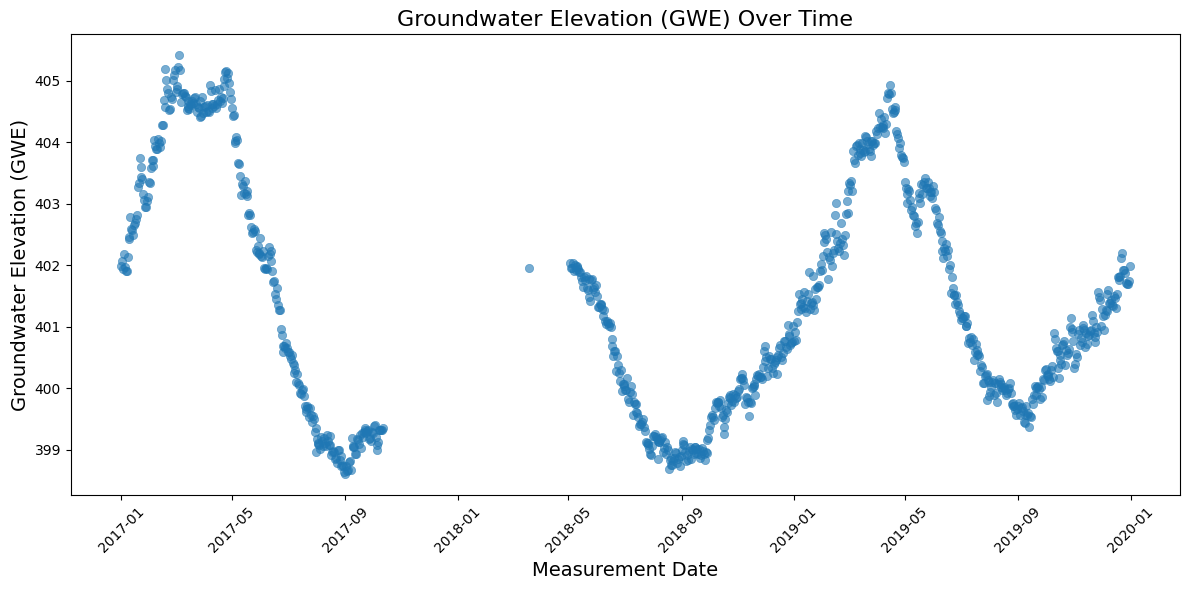

In [198]:
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x='msmt_date',
    y='gwe',
    data=readings_df,
    alpha=0.6,
    edgecolor=None
)


plt.title('Groundwater Elevation (GWE) Over Time', fontsize=16)
plt.xlabel('Measurement Date', fontsize=14)
plt.ylabel('Groundwater Elevation (GWE)', fontsize=14)


plt.xticks(rotation=45)


plt.tight_layout()
plt.show()

16:25:18 - cmdstanpy - INFO - Chain [1] start processing
16:25:20 - cmdstanpy - INFO - Chain [1] done processing


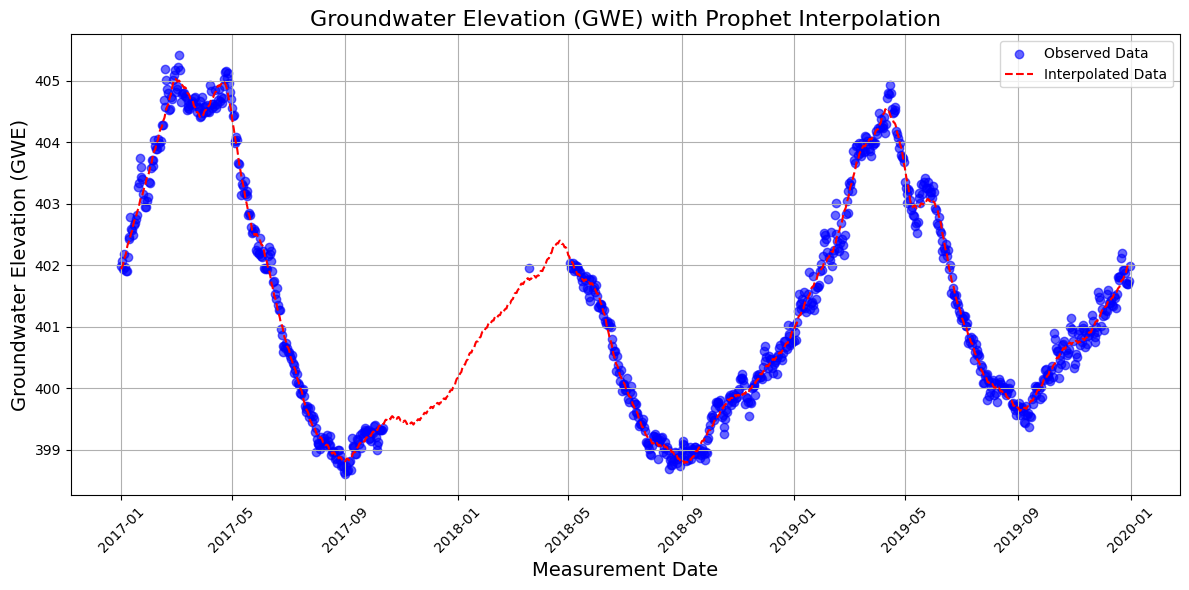

In [199]:
prophet_df = readings_df.rename(columns={"msmt_date": "ds", "gwe": "y"})

# Create a complete date range covering the entire period
full_date_range = pd.date_range(start=prophet_df['ds'].min(), end=prophet_df['ds'].max(), freq='D')
full_df = pd.DataFrame({'ds': full_date_range})

# Merge with the original data to introduce NaNs for missing dates
full_df = full_df.merge(prophet_df, on='ds', how='left')

# Step 2: Train the Prophet model
m = Prophet(yearly_seasonality=True)  # Enable yearly seasonality (12-month period)
m.fit(prophet_df.dropna())  # Fit on the observed data (excluding NaNs)

# Step 3: Generate predictions for the full date range
forecast = m.predict(full_df)

# Step 4: Combine the results
# Add the interpolated values to the full DataFrame
full_df['y_interpolated'] = forecast['yhat']

# Step 5: Plot the results
plt.figure(figsize=(12, 6))
plt.scatter(prophet_df['ds'], prophet_df['y'], color='blue', label='Observed Data', alpha=0.6)
plt.plot(full_df['ds'], full_df['y_interpolated'], color='red', label='Interpolated Data', linestyle='--')
plt.title('Groundwater Elevation (GWE) with Prophet Interpolation', fontsize=16)
plt.xlabel('Measurement Date', fontsize=14)
plt.ylabel('Groundwater Elevation (GWE)', fontsize=14)
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

16:30:28 - cmdstanpy - INFO - Chain [1] start processing
16:30:28 - cmdstanpy - INFO - Chain [1] done processing


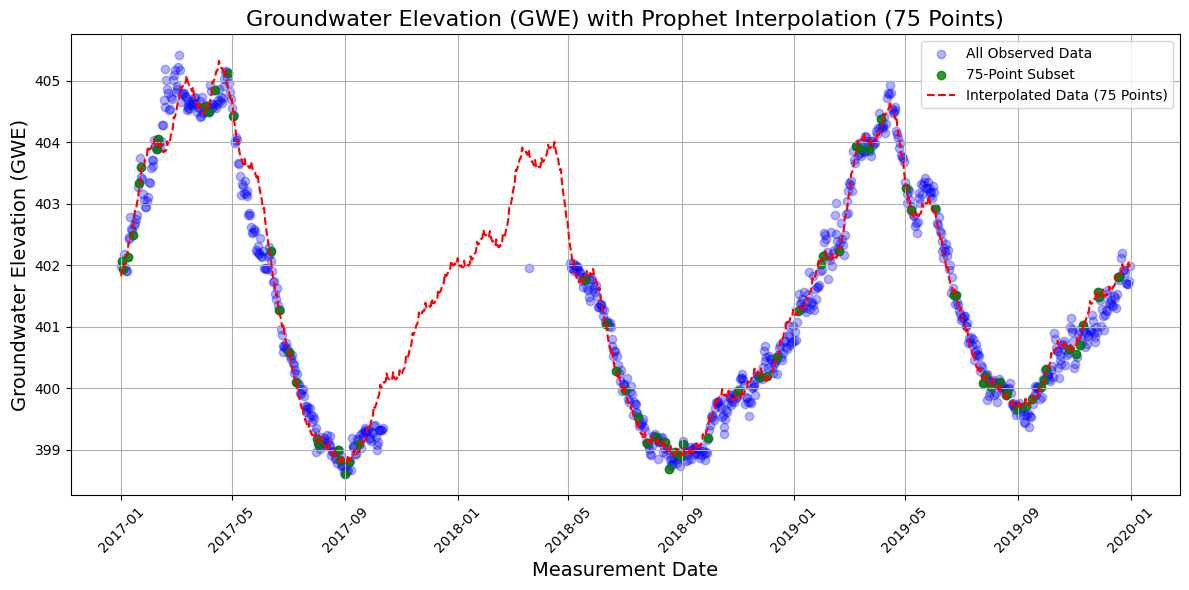

In [209]:
prophet_df = readings_df.rename(columns={"msmt_date": "ds", "gwe": "y"})

# Select only 30 points (e.g., the first 30 observations)
subset_df = prophet_df.sample(n=75)

# Create a complete date range covering the entire period
full_date_range = pd.date_range(start=prophet_df['ds'].min(), end=prophet_df['ds'].max(), freq='D')
full_df = pd.DataFrame({'ds': full_date_range})

# Merge with the subset data to introduce NaNs for missing dates
full_df = full_df.merge(subset_df, on='ds', how='left')

# Step 2: Train the Prophet model on the subset of 30 points
m = Prophet(yearly_seasonality=True)  # Enable yearly seasonality (12-month period)
m.fit(subset_df.dropna())  # Fit on the subset of 30 points

# Step 3: Generate predictions for the full date range
forecast = m.predict(full_df)

# Step 4: Combine the results
# Add the interpolated values to the full DataFrame
full_df['y_interpolated'] = forecast['yhat']

# Step 5: Plot the results
plt.figure(figsize=(12, 6))
plt.scatter(prophet_df['ds'], prophet_df['y'], color='blue', label='All Observed Data', alpha=0.3)
plt.scatter(subset_df['ds'], subset_df['y'], color='green', label='75-Point Subset', alpha=0.8)
plt.plot(full_df['ds'], full_df['y_interpolated'], color='red', label='Interpolated Data (75 Points)', linestyle='--')
plt.title('Groundwater Elevation (GWE) with Prophet Interpolation (75 Points)', fontsize=16)
plt.xlabel('Measurement Date', fontsize=14)
plt.ylabel('Groundwater Elevation (GWE)', fontsize=14)
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()